In [2]:
import sys
import os
from typing import List
sys.path.insert(0, os.path.abspath('..'))

%load_ext autoreload
%autoreload 2

In [3]:
from utils.schemas import Split, ObservationPointer
from utils.data_management import observation_factory

In [4]:
from google.cloud import storage

GCP_PROJECT_NAME = "gee-sand"
BUCKET_NAME = "sand_mining"

gcp_client = storage.Client(project=GCP_PROJECT_NAME)


In [5]:
validation_sites = ["Ken_Banda", "Sone_Rohtas"]

observations: List[ObservationPointer] = list(
    observation_factory(gcp_client, validation_sites)
)

In [6]:
from rastervision.pytorch_learner import SemanticSegmentationSlidingWindowGeoDataset
from config import CLASS_CONFIG_BINARY_SAND as class_config

TILE_SIZE = 220

def get_ds_for_observation(img_uri, label_uri, augmentation, force_full_coverage:bool):
    ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
        image_uri=img_uri,
        label_vector_uri=label_uri,
        class_config=class_config,
        label_vector_default_class_id=class_config.get_class_id('sandmine'),
        size=TILE_SIZE,
        stride=TILE_SIZE,
        padding=TILE_SIZE if force_full_coverage else None,
        pad_direction='end' if force_full_coverage else 'both',
        transform=augmentation,
    )
    return ds

/home/tboehnel/.conda/envs/rastervision/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import albumentations as A

augmentation = A.Compose([
    A.RandomRotate90(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.CoarseDropout(max_height=64, max_width=64, max_holes=5)
])

train_datasets = [
    get_ds_for_observation(
        img_uri=obs.uri_to_rgb,
        label_uri=obs.uri_to_annotations,
        augmentation=augmentation,
        force_full_coverage=False
    )
    for obs in observations if obs.split == Split.TRAIN
]

val_datasets = [
    get_ds_for_observation(
        img_uri=obs.uri_to_rgb,
        label_uri=obs.uri_to_annotations,
        augmentation=None,
        force_full_coverage=True
    )
    for obs in observations if obs.split == Split.VAL
]

In [ ]:
from utils.visualizing import show_windows

for ds_to_visualize in train_datasets:
    show_windows(
        ds_to_visualize.scene.raster_source[:,:],
        ds_to_visualize.windows
    )

In [8]:
from torch.utils.data import ConcatDataset

train_dataset_merged = ConcatDataset(train_datasets)
val_dataset_merged = ConcatDataset(val_datasets)

## Train

In [9]:
from rastervision.pytorch_learner import SemanticSegmentationGeoDataConfig, SolverConfig, SemanticSegmentationLearnerConfig, SemanticSegmentationLearner
from models.unet.unet_small import UNetSmall

_, _, n_channels = train_datasets[0].scene.raster_source.shape
n_classes = 2

model = UNetSmall(n_channels, n_classes)

data_cfg = SemanticSegmentationGeoDataConfig(
    class_names=class_config.names,
    class_colors=class_config.colors,
    num_workers=0,
)

solver_cfg = SolverConfig(
    batch_sz=10,
    lr=3e-2,
    class_loss_weights=[1., 10]
)

learner_cfg = SemanticSegmentationLearnerConfig(data=data_cfg, solver=solver_cfg)

learner = SemanticSegmentationLearner(
    cfg=learner_cfg,
    output_dir='../out/0718-2_rbg',
    model=model,
    train_ds=train_dataset_merged,
    valid_ds=val_dataset_merged, 
)
learner.log_data_stats()

2023-07-18 19:23:04:rastervision.pytorch_learner.learner: INFO - Loading checkpoint from ../out/0718-2_rbg/last-model.pth
2023-07-18 19:23:05:rastervision.pytorch_learner.learner: INFO - train_ds: 564 items
2023-07-18 19:23:05:rastervision.pytorch_learner.learner: INFO - valid_ds: 837 items


In [ ]:
learner.train(epochs=3)

## Evaluate

In [21]:
from rastervision.core.data import SemanticSegmentationLabels

ds_to_eval = val_datasets[4]

predictions = learner.predict_dataset(
    ds_to_eval,
    raw_out=True,
    numpy_out=True,
    progress_bar=True
)

pred_labels = SemanticSegmentationLabels.from_predictions(
    ds_to_eval.windows,
    predictions,
    smooth=True,
    extent=ds_to_eval.scene.extent,
    num_classes=len(class_config)
)

scores = pred_labels.get_score_arr(pred_labels.extent)
predicted_mine_probability = scores[class_config.get_class_id('sandmine')]

Predicting: 100%|██████████| 9/9 [00:00<00:00, 10.33it/s]


#### Visualize predictions

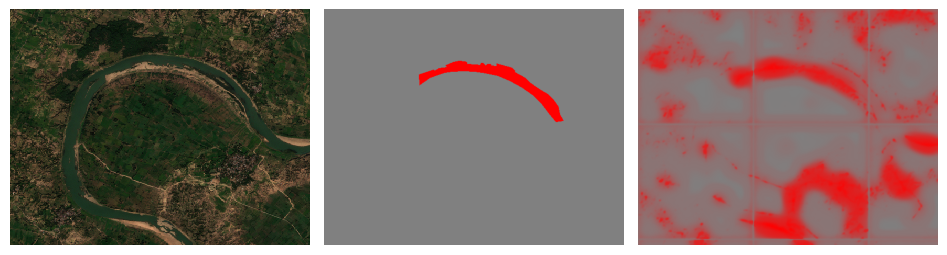

In [22]:
from utils.visualizing import show_rgb_labels_preds

show_rgb_labels_preds(
    ds_to_eval.scene.raster_source[:, :],
    ds_to_eval.scene.label_source[:, :],
    predicted_mine_probability,
)